In [1]:
# load the "autoreload" extension so that code can change
%load_ext autoreload
# always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [2]:
from warnings import filterwarnings
filterwarnings('ignore')

# Normalization of the Power Signal

Author: Clemens Jochum

Normalize the power signal in order to obtain the performance index (PI). The resulting performance index is aggregated daily in order to obtain a daily time-series. The normalization code presented here mirrors the normalization method by Daniel Fregosi that he uses for the input to `rdtools`.

In [3]:
# import necessary functions and libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from src.data.import_data import import_df_from_zip_pkl, import_df_info_from_zip
from src.features.performance_index import normalize_power_signal, detect_pi_outliers
from src.data.make_dataset import downsample_dataframe

### Obtain the reference clearsky irradiance

Obtain the reference clearsky irradiance (POA) for `synthetic_weather` and `synthetic_soil_weather` datasets from external data.

In [4]:
# load reference poa
path_to_poa_reference = '../data/raw/clearsky_poa/clear_sky_CO.pkl'
poa_reference_02 = pd.read_pickle(path_to_poa_reference, compression='gzip')

# pad missing values w/ zeros
t_begin = pd.Timestamp('2015-01-01 00:00:00').tz_localize('Etc/GMT+7')
t_final = pd.Timestamp('2019-12-31 23:59:00').tz_localize('Etc/GMT+7')
datetime_01 = pd.date_range(t_begin, poa_reference_02.index[0], freq='min')[:-1]
datetime_03 = pd.date_range(poa_reference_02.index[-1], t_final, freq='min')[1:]
poa_reference_01 = pd.Series(data=0., index=datetime_01, name='POAcs')
poa_reference_03 = pd.Series(data=0., index=datetime_03, name='POAcs')
poa_reference_co = pd.concat((poa_reference_01, poa_reference_02, poa_reference_03))

### Normalize a Dataset

Normalize the dataset of `data_key`. Example given here is for `data_key = soil_weather`, i.e., the `synthetic_soil_weather` dataset.

In [5]:
# set parameters
data_key = 'soil_weather'
n_samples = 1
path_to_dataset = '../data/raw/synthetic_datasets/synthetic_soil_weather.zip'

In [6]:
# test the data import
df_test = import_df_from_zip_pkl(path_to_dataset, index=n_samples-1, verbose=True)
df_info = import_df_info_from_zip(path_to_dataset, verbose=True)
print(df_test.POA.size == poa_reference_co.size)


importing synthetic_soil_weather/synthetic_soil_weather_001.pkl

time for importing dataframe: 0.68 seconds
Found the following dataset info-files  ['synthetic_soil_weather/synthetic_soil_weather_info.csv']

importing synthetic_soil_weather/synthetic_soil_weather_info.csv

True


In [7]:
# loop over timeseries in dataset
for index in range(n_samples):
    
    # load dataset
    df = import_df_from_zip_pkl(path_to_dataset, index)
    
    # check if clearsky detection is necessary
    if data_key in ['basic', 'soil']:
        clearsky = False
        poa_reference = None
    else:
        clearsky = True
        poa_reference = poa_reference_co
    
    p_norm_daily_clipping_basic = normalize_power_signal(df, poa_reference, clearsky=clearsky, verbose=True)
       
    df_daily = downsample_dataframe(df)
    df_daily['PI_clipping_basic'] = p_norm_daily_clipping_basic
    index_string = str(index+1).zfill(3)
    df_daily.to_pickle(f'../data/processed/new/synthetic_{data_key:s}_pi_daily_{index_string:s}.pkl', compression = 'gzip', protocol = 3)

0.11 % of datapoints remaining after clearsky-detection, nighttime-removal, and clipping-removal


### Visualize Normalization

Visualize the last generated performance index and visualize one saved normalized power-signal, i.e., PI. When importing PI data the function `import_df_from_zip_pkl()` must be called with `minofday=False`. Also show the signal with outliers removed (default values: outliers are below `0.7` and above `1.0`)


PI signal contains 29.85 % NaNs

detected 26 outliers (corresponging to {percent_outliers:.2f} % of non-NaN PI signal)



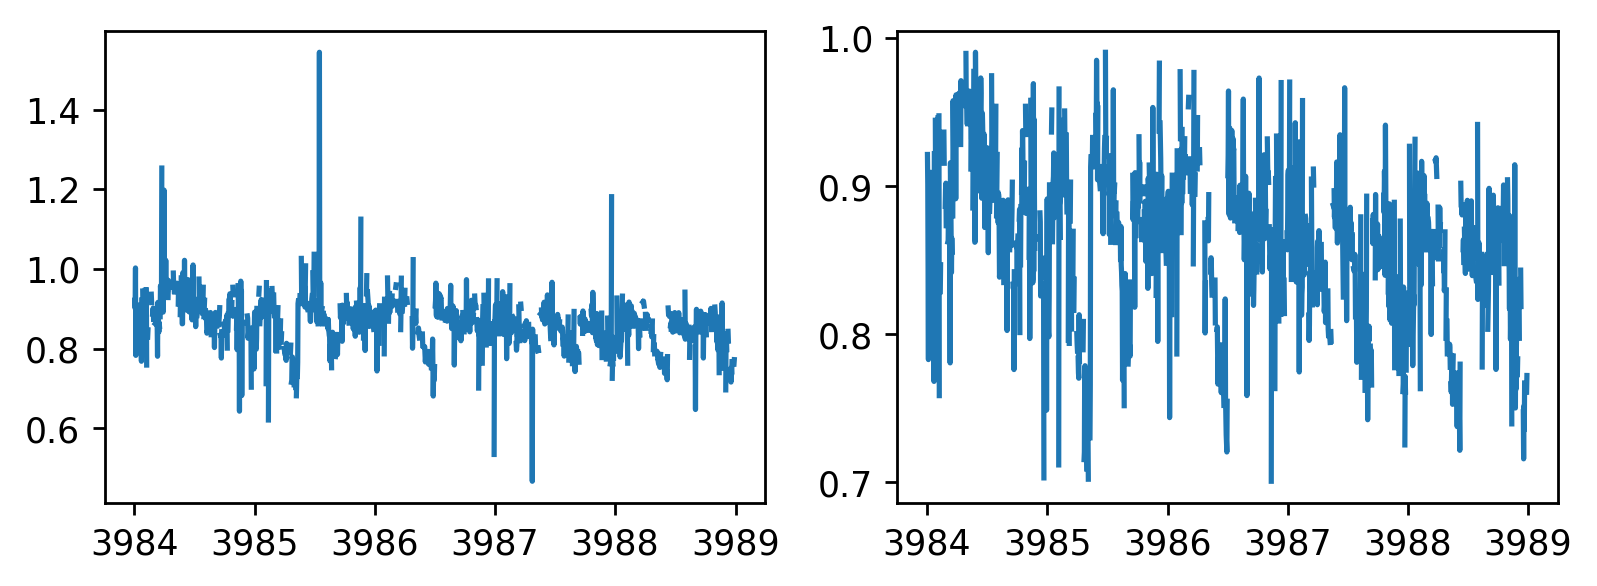


PI signal contains 29.85 % NaNs

detected 26 outliers (corresponging to {percent_outliers:.2f} % of non-NaN PI signal)



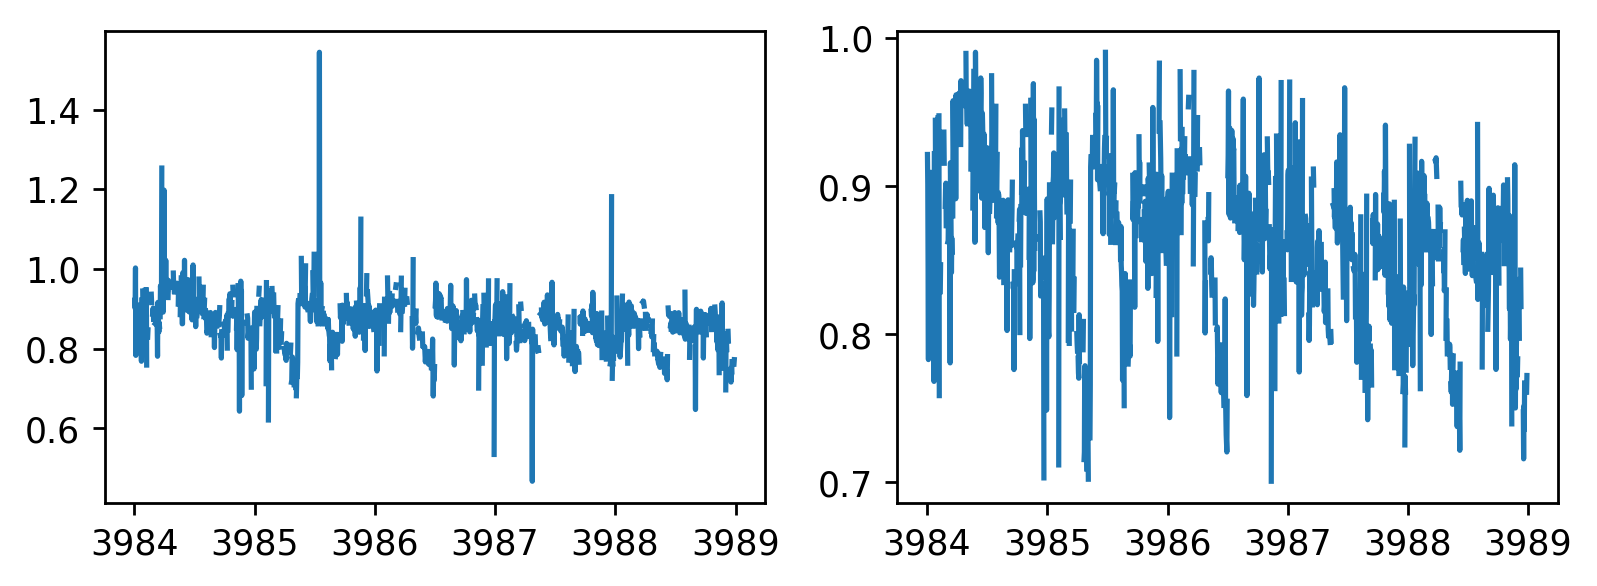

In [8]:
plt.rcParams["figure.figsize"] = [7.5, 2.5]
plt.rcParams['figure.dpi'] = 250

fig, axarr = plt.subplots(1, 2)
axarr[0].plot(df_daily.PI_clipping_basic)
df_daily_wo_ol = df_daily[detect_pi_outliers(df_daily.PI_clipping_basic, verbose=True)[0]].PI_clipping_basic
axarr[1].plot(df_daily_wo_ol)
plt.show()

path_to_pi = '../data/processed/performance_index/synthetic_soil_weather_pi_daily.zip'
df_pi_load = import_df_from_zip_pkl(path_to_pi, index=0, minofday=False, verbose=False)
df_pi_load_wo_ol = df_pi_load[detect_pi_outliers(df_pi_load.PI_clipping_basic, verbose=True)[0]].PI_clipping_basic

fig, axarr = plt.subplots(1, 2)
axarr[0].plot(df_pi_load.PI_clipping_basic)
axarr[1].plot(df_pi_load_wo_ol)
plt.show()